In [152]:
import mesa
import numpy as np
import pandas as pd
import geopandas as gpd 
from geopandas import GeoDataFrame 
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import contextily as ctx
from collections import deque
import networkx as nx
import osgeo
from mesa import Agent, Model
from mesa.time import RandomActivation, BaseScheduler
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import mplleaflet

import osmnx as ox

path=os.getcwd()

In [153]:
dff = pd.read_csv('_roads3.csv')

lijst = dff['road'].unique()

matchers = ['N']
matching = [s for s in lijst if any(xs in s for xs in matchers)]

df2 = dff[dff['name'].str.contains('|'.join(matching))].reset_index().drop('index', axis=1)
side = df2[df2['road'].str.contains('|'.join(matching))].reset_index().drop('index', axis=1)

side = side.reset_index().drop("index", axis=1).rename(columns={'chainage':'km','lrp':'LRPName'})
side['structure'] = 'SideRoad'

side.head()

,road,km,LRPName,lat,lon,gap,type,name,structure
0,N1,8.763,LRP009a,23.706083,90.521527,NaN,"SideRoad,Left",Road to Sylhet (N2),SideRoad
1,N1,11.936,LRP012c,23.690416,90.546583,NaN,"SideRoad,Right",Right to Syedpur (R113) left to Joydebpur N105),SideRoad
2,N1,81.846,LRP084a,23.478972,91.118166,NaN,"SideRoad,Left",Road to Brahmanbaria(N102),SideRoad
3,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,SideRoad
4,N1,229.065,LRP232a,22.393777,91.758806,NaN,"SideRoad,Right","N111, Port Connecting Road",SideRoad


## Getting Starting and Ending points of all roads

In [173]:
startend=[]
all_roads = list(dff.road.unique())
dff = dff[dff.road.str.contains('N') == True]
startend = pd.DataFrame(columns=['road','lat','lon','chainage','name'])
for road in all_roads:
    roaddf= dff.loc[dff.road==road,['road','lat','lon','chainage','name']].groupby(by='chainage')
    startend=startend.append((roaddf.head(1).head(1)))
    startend=startend.append((roaddf.tail(1).tail(1)))
    
startend

,road,lat,lon,chainage,name
0,N1,23.706028,90.443333,0.000,Start of Road after Jatrabari Flyover infront...
1338,N1,20.862917,92.298083,462.254,"End of Road at Shapla Chattar ,Teknaf Meet wit..."
1339,N101,23.454139,91.212861,0.000,Start of Road from N120 at Balutopa
1355,N101,23.459306,91.253389,6.021,End of road Bibir bazar Bridge
1356,N102,23.478972,91.118194,0.000,Start of road from N1 Mainamati
...,...,...,...,...,...
9592,N806,23.160972,89.222666,55.169,End at Traffic more island infront of Monihor ...
9593,N808,23.588916,89.809417,0.000,Start of road from N 804 at Goalchamat infront...
9603,N808,23.567777,89.851444,5.300,End of road at Munshibazar intersect with N 80...
9604,N809,22.685583,90.356806,0.000,"Start from N8 at Amtali Medical more,Barishal"


In [177]:
roads2=[]
for i in range(len(list(startend.road))):
    if i%2==0:
        roads2.append(list(startend.road)[i]+'_start')
    else:
        roads2.append(list(startend.road)[i]+'_end')

startend['road']=roads2

In [178]:
startend

,road,lat,lon,chainage,name
0,N1_start,23.706028,90.443333,0.000,Start of Road after Jatrabari Flyover infront...
1338,N1_end,20.862917,92.298083,462.254,"End of Road at Shapla Chattar ,Teknaf Meet wit..."
1339,N101_start,23.454139,91.212861,0.000,Start of Road from N120 at Balutopa
1355,N101_end,23.459306,91.253389,6.021,End of road Bibir bazar Bridge
1356,N102_start,23.478972,91.118194,0.000,Start of road from N1 Mainamati
...,...,...,...,...,...
9592,N806_end,23.160972,89.222666,55.169,End at Traffic more island infront of Monihor ...
9593,N808_start,23.588916,89.809417,0.000,Start of road from N 804 at Goalchamat infront...
9603,N808_end,23.567777,89.851444,5.300,End of road at Munshibazar intersect with N 80...
9604,N809_start,22.685583,90.356806,0.000,"Start from N8 at Amtali Medical more,Barishal"


In [65]:
#no common lats and lons
yourdf1 = dff[dff[['lat','lon']].nunique(axis=1) == 1]

## Getting Latitude and Longitudes of all intersections

In [155]:
# get a list of names:
names = list(side.name)
n = [name for name in names if name.startswith('N')]
roadintersections= []
ns= []
for i in n:
    ns.append(i.split(' '))
    
for i in ns:
    roadintersections.append(i[0])
intersections=[]
for i in roadintersections:
    if len(i)>=3:
        intersections.append(i[0:4])
    else:
        intersections.append(i[0:2])

len(intersections), len(names)

(36, 170)

In [170]:
inters=[]
interroad=[]
lats=[]
lons=[]
for i in range(len(list(side.name))):
    for j in set(intersections):
        c=0
        if j in list(side.name)[i]:
            if c==0:
                inters.append(j+'_start')
                interroad.append(list(side.road)[i]+'_start')
                lats.append(list(side.lat)[i])
                lons.append(list(side.lon)[i])
                c+=1
            
finalintersections=pd.DataFrame(columns=['road','intersection','lat','lon'])
finalintersections['road']=interroad
finalintersections['intersection']=inters
finalintersections['lat']=lats
finalintersections['lon']=lons

finalintersections

,road,intersection,lat,lon
0,N1_start,N2_start,23.706083,90.521527
1,N1_start,N1_start,23.690416,90.546583
2,N1_start,N1_start,23.478972,91.118166
3,N1_start,N1_start,23.009556,91.381360
4,N1_start,N111_start,22.393777,91.758806
...,...,...,...,...
120,N805_start,N804_start,23.390222,89.983750
121,N805_start,N806_start,23.213556,89.710389
122,N805_start,N805_start,22.990833,89.830416
123,N806_start,N805_start,23.213583,89.710056


## Creating a graph with start, end and road intersections

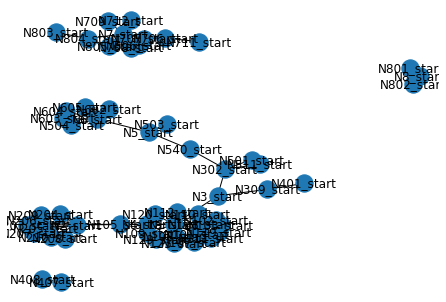

In [179]:
G=nx.Graph()

startend_min = startend[0:14]
#add starting and ending nodes and connect them.

se_roads = list(startend_min.road)

for i in range(len(se_roads)):
    if i<len(se_roads)-1:
        if se_roads[i]==se_roads[i+1]:
            
            #G.add_node(se_roads[i],label=se_roads[i]+'_start')
            #G.add_node(se_roads[i+1],label=se_roads[i+1]+'_end')
            G.add_edge(se_roads[i],se_roads[i+1],length=10)

start_intersection=list(finalintersections.road)
end_intersection=list(finalintersections.intersection)

for i in range(len(start_intersection)):
    G.add_edge(start_intersection[i],end_intersection[i],length=10)
    

nx.draw(G,with_labels=True)

In [205]:
pos={}
G2=nx.Graph()
f5=startend[0:21]

class Road(Agent):
    "Road segments in N1"
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.vehicles=0  #initialize each with 0 vehicles
        #self.condition= f5.loc[f5.LRPName==unique_id,'condition'].values[0]
        self.lat=f5.loc[f5.road==unique_id, 'lat'].values[0]
        self.lon=f5.loc[f5.road==unique_id, 'lon'].values[0]
        self.label = unique_id
        pos[self]=(self.lon, self.lat)
    def step(self):
        pass
     
class Intersection(Agent):
    "Intersections of all the roads"
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.vehicles=0  #initialize each with 0 vehicles
        self.road = finalintersections.loc[all_roads.intersection==unique_id,'intersection'].values[0]
        #self.condition= all_roads.loc[all_roads.LRPName==unique_id,'condition'].values[0]
        self.lat=finalintersections.loc[all_roads.intersection==unique_id, 'lat'].values[0]
        self.lon=finalintersections.loc[all_roads.intersection==unique_id, 'lon'].values[0]
        pos[self]=(self.lon, self.lat)
    def step(self):
        pass
    
    
class N1Model(Model):
    
    "Model to simulate traffic in N1"
    def __init__(self,N):
        self.num_agents= N
        self.schedule= BaseScheduler(self)
        
        #create road start and ending points 
        for i in list(f5.road):  #unique_id for each roadsegment will be its roadname
            roadseg=Road(i,self)
            
            #add agent to schedule
            self.schedule.add(roadseg)
            
            #add agent to graph 
            G2.add_node(roadseg, pos=(roadseg.lat,roadseg.lon), label=roadseg.label)
            
            #search for intersections within this and add them to schedule so that they are in order.
            
            #create intersections 
            #find intersections that are connected to this road
            thisroad= finalintersections.loc[finalintersections.road==i,'intersection']
            list_thisroad= list(thisroad.intersection)  #list of all intersection of this road 
            
            for j in list_thisroad:  #for every intersection in this road:
                inters=Intersection(j,self)  #create an intersection agent 
                #add it to the schedule. this will ensure that the intersections are sandwiched between 
                
            
                #add to schedule 
        
            
        for i in range(len(self.schedule.agents)):
            if(i+1 < len(self.schedule.agents)):
                source=self.schedule.agents[i]
                dest= self.schedule.agents[i+1]
                G2.add_edge(source,dest, length=10)
            
            
    def step(self):
        pass 
    

In [210]:
sample= N1Model(3)
fig,ax= plt.subplots()

nx.draw(G2,pos,with_labels=False)

#plt.show()
mplleaflet.display(fig=ax.figure)

/Users/rtseinstein/anaconda2/envs/networksci/lib/python3.6/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
/Users/rtseinstein/anaconda2/envs/networksci/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
